Enter your name and EID in the following block:

Tarun Gunampalli - tg25522

If you worked with anyone on this homework, please list them below:

Kunal Dhawan  
Aten Kumar

In [67]:
# !pip install tqdm
# !pip install ipywidgets
# !pip install ipywidgets widgetsnbextension pandas-profiling
# !jupyter nbextension enable --py widgetsnbextension

In [2]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_default_tensor_type(torch.FloatTensor)

## Problem 1. Training CNNs on the Fashion MNIST dataset (22 pts)

In this problem, we will build CNNs on a freely available vision dataset, <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST</a>. We have explored this dataset with an MLP architecture and will now try CNNs.

You might recollect that Fashion MNIST consists of many 28x28 grayscale images belonging to 10 different classes of clothing. The task is to train a classifier that can predict the clothing class from the image.

Since several of the steps follow from your work on HW1, you can fill in the misisng pieces much like last time.

In [4]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
from torchvision import datasets, transforms

save_dir = 'fashionMNIST_data'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.FashionMNIST(save_dir, download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST(save_dir, download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fashionMNIST_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: fashionMNIST_data
    Split: Test
    StandardTransform
Transform: ToTensor()


Each of these sets comprises of the image `data` and the clasification `targets`. The `targets` take a numerical value from 1-10 indicating which clothing class each image belongs to.

Since the original data does not have a validation set, let's (once again) create one by splitting the training set.

In [93]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

### Q 1.1: Initialize the train, val and test dataloaders with the given `batch_size` (1 pt)

In [94]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size)

Each loader iterates over the data, yielding `batch_size` images and output targets per iteration.

### Q 1.2: Initialize a CNN with 2-D convolution layer(s), max pooling and finally, fully-connected layer(s). You can add any non-linearity of your choice and use >=1 layer of each type overall. (4 pts)

We have provided the skeleton class definition below. Complete it by specifying the layer objects in your CNN. Keep in mind that the input `x` is of shape (`batch_size`, 1, 28, 28). Unlike the MLP, you do not have to flatten it to feed it into the model. Additionally, the output should be of shape (`batch_size`, 10) as we have 10 classes.

In [95]:
class fashionMLP(nn.Module):
    def __init__(self):        
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, padding='same'),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=4),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=4),
            
            nn.Flatten(),
            
            nn.Linear(32, 8),
            nn.GELU(),
            
            nn.Linear(8, 10, bias=False),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

Tip: An easy way to check if you got the dimensions right is to test your model on a single batch. Iteratively add each layer transformation to the input, and ensure the shape is right at each stage.

In [96]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
#     break
    model = fashionMLP()
    outputs = model(images)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 10])


C:\Users\tarun\miniconda3\envs\CS-342\lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,


### Q 1.3: Define `criterion` to be the cross entropy loss function and use an optimizer of your choice (2 pts)

In [97]:
model = fashionMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=6e-3)

### Q 1.4: Complete the training, validation and testing loops (5 pts)

In [146]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        val_losses = []
        early_exit_thresh = 1.075
        stop_training = False
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                val_loss = total_loss/count
                val_losses.append(val_loss)
                # early exit strategy
                if len(val_losses) > 3 and (min(val_losses[-3:]) > (min(val_losses) * early_exit_thresh) or min(val_losses[-6:]) > min(val_losses)):
                    stop_training = True
                print('{:>12s} {:>7.5f}'.format('Val loss:', val_loss))
            print()
            if stop_training:
                break
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.max(outputs, dim=1).indices # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

### Q 1.5: Train the network and report the final test accuracy of your model (2 pts)
Use the functions `train_network` and `test_network` defined above.

In [35]:
train_network(model, train_loader, val_loader, criterion, optimizer, 50)

acc, true, pred = test_network(model, test_loader, "Test")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.59101
   Val loss: 0.41236

EPOCH 1
 Train loss: 0.38987
   Val loss: 0.35700

EPOCH 2
 Train loss: 0.34644
   Val loss: 0.34271

EPOCH 3
 Train loss: 0.31988
   Val loss: 0.34694

EPOCH 4
 Train loss: 0.29817
   Val loss: 0.30530

EPOCH 5
 Train loss: 0.28641
   Val loss: 0.29054

EPOCH 6
 Train loss: 0.27452
   Val loss: 0.29355

EPOCH 7
 Train loss: 0.26526
   Val loss: 0.29418

EPOCH 8
 Train loss: 0.26058
   Val loss: 0.26307

EPOCH 9
 Train loss: 0.24913
   Val loss: 0.29423

EPOCH 10
 Train loss: 0.24480
   Val loss: 0.27849

EPOCH 11
 Train loss: 0.24036
   Val loss: 0.29538

EPOCH 12
 Train loss: 0.23439
   Val loss: 0.30999

EPOCH 13
 Train loss: 0.23061
   Val loss: 0.28617

Test accuracy: 88.890


### Q 1.6: Which class did the model get wrong the most? Which class did it get right the most? (2 pts)

In [38]:
classes = train_set.classes
num_classes = len(classes)

totals = [0] * num_classes
right = [0] * num_classes
for i in range(len(true)):
    c = true[i]
    totals[c] += 1
    if true[i] == pred[i]:
        right[c] += 1

class_accuracies = {c: 0 for c in classes}
for i in range(num_classes):
    class_accuracies[classes[i]] = right[i] / totals[i]
    
sorted(class_accuracies.items(), key=lambda x:x[1])

[('Shirt', 0.719),
 ('Pullover', 0.809),
 ('T-shirt/top', 0.815),
 ('Coat', 0.868),
 ('Dress', 0.884),
 ('Sneaker', 0.902),
 ('Sandal', 0.962),
 ('Trouser', 0.97),
 ('Bag', 0.976),
 ('Ankle boot', 0.984)]

The model got t-shirts and shirts wrong the most, and it got trousers, bags, and sneakers correct the most.

### Q 1.7: Add any regularization method of your choice (or more than one!), and report the final test accuracy (4 pts)
 You should be able to get accuracy > 90%.

In [39]:
class regularized_fashionMLP(nn.Module):
    def __init__(self):
        kernel_size = 3
        output_dim = 10
        
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size, padding=1),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size),
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.Flatten(),
            nn.Linear(2304, 144),
            nn.GELU(),
            
            nn.Dropout(0.2),
            nn.Linear(144, 24),
            nn.GELU(),
            
            nn.Dropout(0.3),
            nn.Linear(24, output_dim, bias=False),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [41]:
# Instantiate the model, criterion, and optimizer
regmodel = regularized_fashionMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(regmodel.parameters(), lr=6e-3)

# Train the model
train_network(regmodel, train_loader, val_loader, criterion, optimizer, 50)

regmodel.eval() # disables some regularization methods for model testing

# Report test accuracy
acc, true, pred = test_network(regmodel, test_loader, "Test")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.57150
   Val loss: 0.40948

EPOCH 1
 Train loss: 0.40545
   Val loss: 0.40345

EPOCH 2
 Train loss: 0.36396
   Val loss: 0.40298

EPOCH 3
 Train loss: 0.33717
   Val loss: 0.36704

EPOCH 4
 Train loss: 0.31793
   Val loss: 0.36769

EPOCH 5
 Train loss: 0.30375
   Val loss: 0.37817

EPOCH 6
 Train loss: 0.30367
   Val loss: 0.35890

EPOCH 7
 Train loss: 0.28241
   Val loss: 0.36964

EPOCH 8
 Train loss: 0.28122
   Val loss: 0.37805

EPOCH 9
 Train loss: 0.26992
   Val loss: 0.42318

EPOCH 10
 Train loss: 0.26890
   Val loss: 0.39533

EPOCH 11
 Train loss: 0.25646
   Val loss: 0.36676

EPOCH 12
 Train loss: 0.25682
   Val loss: 0.37677

Test accuracy: 90.270


### Q 1.8: Visualize learned kernels from first layer of your CNN (2 pts)

You can either plot them separately (i.e. each as one panel in a plot) or stack them together into a single array. In either case, use matplotlib `imshow` or `matshow` to make an image of each kernel.

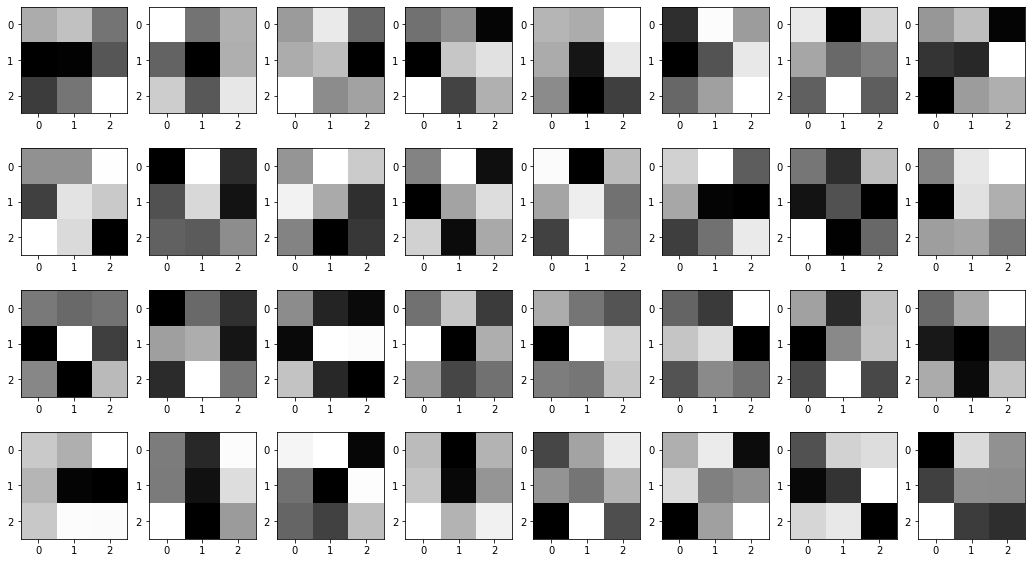

In [42]:
# first, extract the weights from the learned model
conv1wt = regmodel.layers[0].weight.detach().numpy()
# print(conv1wt)
# then, visualize them!
fig, axes = plt.subplots(4, 8, figsize=(18, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(conv1wt[i][0], cmap='gray')

## Problem 2. Training 1-D CNNs for phoneme classification (34 pts)

In this problem, we will build CNNs to classify phonemes from speech features. Instead of using the raw audio waveform as the input to a neural network, we can extract relevant features from the power spectrum of the waveform. Since this is not relevant for our exercise, we have precomputed speech features for you on the input waveform. The data comprises different episodes from a podcast _The Moth Radio Hour_ wherein a single speaker narrates a personal story. You can find it in `HW2_phone_class_data`.
<br><br>
Speech Features: These are 240-D features extracted for every 10ms snippet in a story.
<br>
Phoneme labels: We give you the raw labels and the associated start and end time of the phoneme.
<br><br>
Note that the speech features were extracted at a much higher sampling rate than the typical frequency of a phoneme. Consequeently, there are several speech features occuring between the start and end time of a single phoneme. To predict a single phoneme label, we will firstly consider a `window_size` of 10. Next, we will pick the 10 speech features that occurred right before the phoneme ended. For example, consider a hypothetical scenario where a phoneme started at 1:00 min and ended at 3:00 min, and the speech features were collected every 10s. Then, we would extract features at `[3:00 min, 2:50 min, 2:40 min, 2:30 min, 2:20 min, 2:10 min, 2:00 min, 1:50 min, 1:40 min and 1:30 min]`, ie., the last 10 features.
<br><br>
Next, we will do 1-D convolutions on `[batch_size, 240, 10]` dimensional inputs. Note that `240` here represents the input channels and you want to convolve over the context, ie., the `10` features.

Finally, we will use a hidden test set to evaluate your model. In most real-world applications, you don't have access to your test data and its important to not overfit on your validation set. So make sure you do hyperparameter tuning in moderation!

In [11]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [12]:
# Load the stories in the training and validation set.
import pickle
with open('HW2_phone_class_data/data_split.pickle', 'rb') as f:
    data_split_stories = pickle.load(f)
for key in data_split_stories:
    print(key)
    print(data_split_stories[key])
stories = np.concatenate([data_split_stories[key] for key in data_split_stories])
print(len(stories))

train
['souls' 'wheretheressmoke' 'thatthingonmyarm' 'hangtime' 'adollshouse'
 'odetostepfather' 'sloth' 'myfirstdaywiththeyankees' 'buck' 'avatar'
 'adventuresinsayingyes' 'exorcism' 'naked' 'haveyoumethimyet'
 'stagefright' 'undertheinfluence' 'swimmingwithastronauts' 'itsabox'
 'alternateithicatom' 'fromboyhoodtofatherhood']
val
['theclosetthatateeverything' 'tildeath' 'legacy']
23


In [13]:
# For each story, load the pre-computed speech features and their associated timestamps.
# Also load the phoneme transcriptions and the associated start/end times.
speech_features, speech_timestamps, phonemes, phoneme_start_times, phoneme_end_times = [{} for _ in range(5)]
for story in stories:
    LOAD = np.load('HW2_phone_class_data/%s.npz'%story)
    speech_features[story] = LOAD['fbank_features']
    speech_timestamps[story] = LOAD['fbank_timestamps']
    phonemes[story] = LOAD['phonemes']
    phoneme_start_times[story] = LOAD['phoneme_start_times']
    phoneme_end_times[story] = LOAD['phoneme_end_times']
    print(story)
    print(speech_features[story].shape, speech_timestamps[story].shape)
    print(phonemes[story].shape, phoneme_start_times[story].shape, phoneme_end_times[story].shape)

souls
(72997, 240) (72997,)
(6819,) (6819,) (6819,)
wheretheressmoke
(60191, 240) (60191,)
(6068,) (6068,) (6068,)
thatthingonmyarm
(88875, 240) (88875,)
(7080,) (7080,) (7080,)
hangtime
(66830, 240) (66830,)
(6423,) (6423,) (6423,)
adollshouse
(50353, 240) (50353,)
(5412,) (5412,) (5412,)
odetostepfather
(82808, 240) (82808,)
(8334,) (8334,) (8334,)
sloth
(89497, 240) (89497,)
(8595,) (8595,) (8595,)
myfirstdaywiththeyankees
(73686, 240) (73686,)
(8866,) (8866,) (8866,)
buck
(68498, 240) (68498,)
(5455,) (5455,) (5455,)
avatar
(75423, 240) (75423,)
(5171,) (5171,) (5171,)
adventuresinsayingyes
(80356, 240) (80356,)
(7850,) (7850,) (7850,)
exorcism
(95501, 240) (95501,)
(9952,) (9952,) (9952,)
naked
(86502, 240) (86502,)
(10281,) (10281,) (10281,)
haveyoumethimyet
(101320, 240) (101320,)
(10176,) (10176,) (10176,)
stagefright
(60698, 240) (60698,)
(6669,) (6669,) (6669,)
undertheinfluence
(62772, 240) (62772,)
(5932,) (5932,) (5932,)
swimmingwithastronauts
(79121, 240) (79121,)
(7318,)

### Q 2.1 Create classifier target dictionary (2 pts)

In [14]:
# Load the phoneme_classes which are the target of our CNN classifier.
phoneme_classes = np.load('HW2_phone_class_data/phoneme_classes.npz')['arr_0']
print(phoneme_classes)
nclass = len(phoneme_classes)
print('Number of classes:', nclass)
# Create a dictionary mapping from the phoneme classes to an ID.
# For example, if you were builiding a classifier of dog vs. cat,
# this could be {'dog': 0, 'cat': 1} and [0, 1] would be your classifier targets.
phone2int = {p : i for i, p in enumerate(phoneme_classes)}

['SIL' 'S' 'AY' 'EY' 'T' 'Y' 'ER' 'HH' 'SP' 'BR ' 'Z' 'AA' 'IY' 'OW' 'R'
 'IH' 'BR' 'AO' 'DH' 'M' 'AH' 'B' 'K' 'L' 'W' 'EH' 'N' 'UW' 'OY' 'D' 'CH'
 'F' 'NG' 'AE' 'AW' 'SH' 'P' 'TH' 'LG' 'LS' 'G' 'JH' 'V' 'UH' 'NS' 'CG' ''
 'SPM' 'AHN' 'SP\x7f' 'SPAH' 'ZH' '{NS}' '{IG}' '{CG}' 'ST' 'OA' 'OH' 'U'
 ' IY' ' AY' 'N ' 'A']
Number of classes: 63


### Q 2.2 Create features and labels by aligning timestamps (4 points)

In [15]:
from collections import defaultdict
window_size = 10
features, labels = defaultdict(list), defaultdict(list)

for story in stories:
    print(story)
    # For each phoneme in the story, store a list of speech timestamps `t`
    # such that phoneme_start_time <= t <= phoneme_end_time.
    # This is an example of what `phoneme_time_windows` could look like:
    # [[0,1,2,5..10], [11,12,..27]...., [10000, 10001, ...10012]]
    # In the above example, the first 10 speech features map to the first phoneme,
    # features 11-27 match to second phoneme etc..
    phoneme_time_windows = [[] for _ in range(len(phonemes[story]))]
    for ix in range(len(phonemes[story])):
        after_start = speech_timestamps[story] >= phoneme_start_times[story][ix]
        before_end = speech_timestamps[story] <= phoneme_end_times[story][ix]
        phoneme_time_windows[ix] = np.where(after_start & before_end)[0]
    for ix in range(len(phoneme_time_windows)):
        phoneme_time_windows[ix] = np.array(phoneme_time_windows[ix])
    # Compute and print the average number of speech features that match to 1 phoneme.
    # For example, for a story there could on average be 13 features per phoneme.
    # Store this value in `ptw_mean_length`. We will compute the difference between your
    # variable and our pre-computed values to grade.
    ptw_mean_length = sum(len(ptw) for ptw in phoneme_time_windows) / len(phoneme_time_windows)
    # Finally, we are going to select the 10 most recent features per phoneme
    # and create our dataset.
    for ix in range(len(phoneme_time_windows)):
        # Discard any data points for which fewer than `window_size` speech features
        # map onto the phoneme.
        if len(phoneme_time_windows[ix]) < window_size:
            continue
        ph = phonemes[story][ix].upper().strip("0123456789")
        # Append the phoneme class ID.
        labels[story].append(phone2int[ph])
        # Append the `window_size` most recent features.
        # You will have to make use of `phoneme_time_windows` of course to find the labels.
        features[story].append(speech_features[story][phoneme_time_windows[ix][-window_size:]])
    labels[story]= np.array(labels[story])
    features[story] = np.array(features[story])
    print(labels[story].shape, features[story].shape)
    
    # Just making sure everything iss the right shape!
    assert not np.any(np.isnan(features[story])), story
    assert labels[story].shape[0] == features[story].shape[0]
    assert np.all(features[story].shape[1:] == (window_size, 240))

souls
(2334,) (2334, 10, 240)
wheretheressmoke
(1782,) (1782, 10, 240)
thatthingonmyarm
(3264,) (3264, 10, 240)
hangtime
(2330,) (2330, 10, 240)
adollshouse
(1136,) (1136, 10, 240)
odetostepfather
(2711,) (2711, 10, 240)
sloth
(2921,) (2921, 10, 240)
myfirstdaywiththeyankees
(2197,) (2197, 10, 240)
buck
(1994,) (1994, 10, 240)
avatar
(2373,) (2373, 10, 240)
adventuresinsayingyes
(2732,) (2732, 10, 240)
exorcism
(3210,) (3210, 10, 240)
naked
(2472,) (2472, 10, 240)
haveyoumethimyet
(2572,) (2572, 10, 240)
stagefright
(1900,) (1900, 10, 240)
undertheinfluence
(1643,) (1643, 10, 240)
swimmingwithastronauts
(2420,) (2420, 10, 240)
itsabox
(2109,) (2109, 10, 240)
alternateithicatom
(2361,) (2361, 10, 240)
fromboyhoodtofatherhood
(2332,) (2332, 10, 240)
theclosetthatateeverything
(2027,) (2027, 10, 240)
tildeath
(1987,) (1987, 10, 240)
legacy
(2249,) (2249, 10, 240)


### Q 2.3 Set up the dataloaders (2 points)

In [16]:
batch_size = 1024

# Stack all the speech features of the training set stories.
# It is recommended to swap the 240-D and 10-D axes to make the convolution easier.
train_feats = [features[story] for story in data_split_stories['train']]
train_feats = np.transpose(np.vstack(train_feats), (0, 2, 1))
# Stack all the phoneme labels of the training set stories.
train_labels = [labels[story] for story in data_split_stories['train']]
train_labels = np.hstack(train_labels)
print(train_feats.shape, train_labels.shape)
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_feats), torch.tensor(train_labels).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)

# Repeat the process for the validation set.
val_feats = [features[story] for story in data_split_stories['val']]
val_feats = np.transpose(np.vstack(val_feats), (0, 2, 1))
val_labels = [labels[story] for story in data_split_stories['val']]
val_labels = np.hstack(val_labels)
print(val_feats.shape, val_labels.shape)
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_feats), torch.tensor(val_labels).type(torch.LongTensor))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size)

### NOTE: It is super important that you double check your array shapes.

(46793, 240, 10) (46793,)
(6263, 240, 10) (6263,)


### Q 2.4 Set up the training function. Note that this is identical to the FashionMNIST question (3 points)

In [17]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        val_losses = []
        early_exit_thresh = 1.01
        stop_training = False
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                val_loss = total_loss/count
                print('{:>12s} {:>7.5f}'.format('Val loss:', val_loss))
                val_losses.append(val_loss)
                # early exit strategy
                if len(val_losses) > 3 and (min(val_losses[-6:]) > (min(val_losses) * early_exit_thresh) or min(val_losses[-12:]) > min(val_losses)):
                    stop_training = True
                    print('Early exitting due to increasing/stagnant validation loss')
            print()
            # early exit
            if stop_training:
                break
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

### Q 2.5 Define your CNN architecture. (3 points)

- Make sure to use at least two 1-D convolution layers followed by at least one fully connected layers.
- You will again find functions like `reshape`, `view`, `flatten` useful.
- Your convolutions should treat the 240-D as _channels_ and combine information over the context, ie., the 10-D.
- Build your model incrementally by checking the resultant output shape for each new layer you add! Test with an example batch.

Documentation for Conv1D: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html

In [18]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=240, out_channels=160, kernel_size=2),
            nn.ReLU(),
            
            nn.Conv1d(in_channels=160, out_channels=80, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=3),
            
            nn.Flatten(),
            
            nn.Linear(160, 128),
            nn.ReLU(),
            
            nn.Linear(128, 63),
        )

    def forward(self, x):
        return self.layers(x)
    
for waves, labels in train_loader:
    print(waves.shape, labels.shape)
    model = CNNModel()
    outputs = model(waves)
    print(outputs.shape)
    break

torch.Size([1024, 240, 10]) torch.Size([1024])
torch.Size([1024, 63])


### Q 2.6 Define your optimizeer and criterion for the phoneme classifier. (2 points)

In [11]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-3)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

### Q 2.7 How are weights and biases being initialized for the convolution layers? (2 pts)

Pytorch initializes the weights and biases for the convolutional layers using a uniform distribution between $-\sqrt{k}$ and $\sqrt{k}$, where $k$, in our case, is $\frac{1}{C_{in} * kernel\_size}$.

### Q 2.8 Train your network (5 pts)
- Make sure you tune the hyperparameters!

In [12]:
model.train()
train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100)

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.31580
   Val loss: 2.05493

EPOCH 1
 Train loss: 1.75055
   Val loss: 2.03893

EPOCH 2
 Train loss: 1.57638
   Val loss: 1.90632

EPOCH 3
 Train loss: 1.45601
   Val loss: 1.80719

EPOCH 4
 Train loss: 1.40147
   Val loss: 1.87617

EPOCH 5
 Train loss: 1.35334
   Val loss: 1.72643

EPOCH 6
 Train loss: 1.28965
   Val loss: 1.70504

EPOCH 7
 Train loss: 1.25381
   Val loss: 1.72419

EPOCH 8
 Train loss: 1.22966
   Val loss: 1.75533

EPOCH 9
 Train loss: 1.19559
   Val loss: 1.75007

EPOCH 10
 Train loss: 1.17768
   Val loss: 1.72910

EPOCH 11
 Train loss: 1.14610
   Val loss: 1.74621

EPOCH 12
 Train loss: 1.11766
   Val loss: 1.73758
Early exitting due to increasing/stagnant validation loss



### Q 2.9 Set up the test function. Note that this is identical to the FashionMNIST question (3 pts)

In [13]:
def test_network(model, test_loader, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.max(outputs, dim=1).indices # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

### Q 2.10 Write a function that takes in the model predictions and true labels, and returns the accuracy per phoneme class as a dictionary (3 pts)

For example, if the true labels contain 10 instances of the phoneme class "AY" and the model predicts this correctly 5 times, the entry `class_accuracy['AY'] = 0.5`.

In [14]:
def report_test_results(precomputed_acc, model_true, model_pred):
    # Accuracy per phoneme class.
    class_accuracy = {}
    total_correct = 0
    for ph, i in phone2int.items():
        instances = (model_true == i).sum()
        correct = ((model_true == i) & (model_true == model_pred)).sum()
        class_accuracy[ph] = -1 if instances == 0 else correct / instances
        total_correct += correct
    total_acc = total_correct / len(model_pred) * 100
    # Write an assertion to check that the sum of correctly predicted
    # labels across all classes is equal to the total accuracy of the model.
    # It is good (and important) to always run such sanity checks!
    # PS. You will probably have to define more variables.
    assert np.allclose(total_acc, precomputed_acc)
    # Sort the phoneme classes in increasing order of accuracy.
    sorted_phones = sorted(class_accuracy.items(), key=lambda x:x[1])
    print('Top-3 predicted phones:', sorted_phones[-3:])
    return class_accuracy

### Q 2.11 Run tests on the validation data (2 pts)

In [15]:
model.eval()

val_precomputed_acc, val_model_true, val_model_pred = test_network(model, val_loader, 'Test')
val_class_accuracy = report_test_results(
    val_precomputed_acc, val_model_true, val_model_pred)

Test accuracy: 52.898
Top-3 predicted phones: [('SP', 0.7551319648093842), ('IY', 0.7840531561461794), ('S', 0.8298319327731093)]


### Q 2.12 Print the validation class accuracy for the given phoneme classes. What do you observe? What could be the reason for this? (2 pts)

HINT: The answer is UNRELATED to the model.

In [16]:
for phoneme in ['OH', 'U']:
    print(val_class_accuracy[phoneme])

0.0
0.0


The accuracy for the given phoneme classes is always 0. This is likely because of two possible reasons, firstly because there might be very few instances for each of those phonemes and the model happened to predict all of them incorrectly, and secondly because the two phonemes given sound similar to each other, so it might be harder to classify as different classes, which makes sense when looking at the best predicted sounds that have seemingly distinct sound patterns.

### Q 2.13 We will now test your model on a hidden test set. So make sure your model definition and functions to compute test accuracy are clearly defined! (2 pts)

_(there is nothing for you to do here, this block exists for grading purposes only)_

In [17]:
data_split_stories['test'] = ['inamoment', 'eyespy', 'life', 'howtodraw']

for story in data_split_stories['test']:
    LOAD = np.load('HW2_phone_class_data/%s.npz'%story)
    speech_features[story] = LOAD['fbank_features']
    speech_timestamps[story] = LOAD['fbank_timestamps']
    phonemes[story] = LOAD['phonemes']
    phoneme_start_times[story] = LOAD['phoneme_start_times']
    phoneme_end_times[story] = LOAD['phoneme_end_times']
    print(story)
    print(speech_features[story].shape, speech_timestamps[story].shape)
    print(phonemes[story].shape, phoneme_start_times[story].shape, phoneme_end_times[story].shape)
    
features, labels = defaultdict(list), defaultdict(list)

for story in data_split_stories['test']:
    print(story)
    phoneme_time_windows = [[] for _ in range(len(phonemes[story]))]
    for time_index, time in enumerate(speech_timestamps[story]):
        # Find position which starts at or right before this timestamp.
        ix = np.where(phoneme_start_times[story] <= time)[0][-1]
        if phoneme_end_times[story][ix] > time:
            phoneme_time_windows[ix].append(time_index)
    for ix in range(len(phoneme_time_windows)):
        phoneme_time_windows[ix] = np.array(phoneme_time_windows[ix])
    ptw_lengths = np.array([len(ptw) for ptw in phoneme_time_windows])
    print(ptw_lengths.mean(), ptw_lengths.std())
    for ix in range(len(phoneme_time_windows)):
        if len(phoneme_time_windows[ix]) < window_size:
            continue
        ph = phonemes[story][ix].upper().strip("0123456789")
        labels[story].append(phone2int[ph])
        features[story].append(speech_features[story][phoneme_time_windows[ix]][-window_size:])
    labels[story]= np.array(labels[story])
    features[story] = np.array(features[story])
    print(labels[story].shape, features[story].shape)
    
    assert not np.any(np.isnan(features[story])), story
    assert labels[story].shape[0] == features[story].shape[0]
    assert np.all(features[story].shape[1:] == (window_size, 240))
    
# Set up the dataloaders
test_feats = np.vstack([features[story] for story in data_split_stories['test']])
test_feats = np.swapaxes(test_feats, 1, 2)
test_labels = np.hstack([labels[story] for story in data_split_stories['test']])
print(test_feats.shape, test_labels.shape)
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_feats), torch.tensor(test_labels))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

precomputed_acc, model_true, model_pred = test_network(model, test_loader, 'test')
report_test_results(precomputed_acc, model_true, model_pred)

inamoment
(43031, 240) (43031,)
(3494,) (3494,) (3494,)
eyespy
(77941, 240) (77941,)
(7920,) (7920,) (7920,)
life
(88025, 240) (88025,)
(7296,) (7296,) (7296,)
howtodraw
(72825, 240) (72825,)
(6952,) (6952,) (6952,)
inamoment
12.315397824842588 24.093445441069974
(1459,) (1459, 10, 240)
eyespy
9.840909090909092 16.412615041695428
(2277,) (2277, 10, 240)
life
12.062088815789474 16.058891727998713
(3022,) (3022, 10, 240)
howtodraw
10.47511507479862 15.877351474077999
(2477,) (2477, 10, 240)
(9235, 240, 10) (9235,)
test accuracy: 55.138
Top-3 predicted phones: [('K', 0.7902298850574713), ('IY', 0.8792372881355932), ('S', 0.8979591836734694)]


{'SIL': -1,
 'S': 0.8979591836734694,
 'AY': 0.7268370607028753,
 'EY': 0.5162790697674419,
 'T': 0.601823708206687,
 'Y': 0.33663366336633666,
 'ER': 0.4734848484848485,
 'HH': 0.49079754601226994,
 'SP': 0.7474012474012474,
 'BR ': -1,
 'Z': 0.5,
 'AA': 0.5205992509363296,
 'IY': 0.8792372881355932,
 'OW': 0.5060728744939271,
 'R': 0.5125,
 'IH': 0.2926829268292683,
 'BR': 0.2463768115942029,
 'AO': 0.1956521739130435,
 'DH': 0.10526315789473684,
 'M': 0.5213675213675214,
 'AH': 0.042483660130718956,
 'B': 0.203125,
 'K': 0.7902298850574713,
 'L': 0.5096774193548387,
 'W': 0.7346938775510204,
 'EH': 0.15151515151515152,
 'N': 0.5759493670886076,
 'UW': 0.5271317829457365,
 'OY': 0.25,
 'D': 0.3937007874015748,
 'CH': 0.40298507462686567,
 'F': 0.6588235294117647,
 'NG': 0.44370860927152317,
 'AE': 0.6521739130434783,
 'AW': 0.44370860927152317,
 'SH': 0.4015151515151515,
 'P': 0.10067114093959731,
 'TH': 0.19444444444444445,
 'LG': 0.14285714285714285,
 'LS': 0.14285714285714285,
 'G

### Q 2.14 Can you reuse your model as is with a different `window_size`? Why or why not? (2 pts)

While the different window size would break at the linear layers because of the different dimension size, I think the model could be reused with a different window size if the linear layer input size was changed, but it would probably be better to take advantage of the higher size dimension by also increasing the 1d convolution layer kernel size to try to recognize longer sounds.

### Q 2.15 Can you reuse your model as is with a different dimensionality of speech features? Why or why not? (2 pts)

No, the dimensions would still break on the convolution and linear layers due to the different dimension sizes, since the number of input channels into the conv1d layer would be different.

## Problem 3. 1-D CNNs and model interpretation (27 pts)

In this problem you will again train a 1-D CNN on audio data, here to classify spoken numerals (e.g. "one", "two"). Then you will use additional techniques to interpret (since it's audio, one can't really say "visualize", but same idea) what the model is doing. Run these cells first to set things up.

In [6]:
import IPython.display as ipd

import torchaudio
from torchaudio import datasets as audiodatasets

audio_save_dir = './SPEECHCOMMANDS_data' # set to wherever you want to keep these files
sc_training = audiodatasets.SPEECHCOMMANDS(audio_save_dir, download=True, subset="training")
sc_validation = audiodatasets.SPEECHCOMMANDS(audio_save_dir, download=True, subset="validation")
sc_testing = audiodatasets.SPEECHCOMMANDS(audio_save_dir, download=True, subset="testing")

In [7]:
# the audio will be downsampled to 8 kHz to make it easier to work with. just run this
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=new_sample_rate)

In [8]:
# the dataset contains a lot of words, but let's focus on the numbers
sel_labels = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

training_inds, validation_inds, testing_inds = (None, None, None)
%store -r training_inds
%store -r validation_inds 
%store -r testing_inds

training_inds = training_inds if training_inds is not None else np.array([ii for ii,datum in enumerate(sc_training) if datum[2] in sel_labels])
validation_inds = validation_inds if validation_inds is not None else np.array([ii for ii,datum in enumerate(sc_validation) if datum[2] in sel_labels])
testing_inds = testing_inds if testing_inds is not None else np.array([ii for ii,datum in enumerate(sc_testing) if datum[2] in sel_labels])

%store training_inds
%store validation_inds
%store testing_inds
print(training_inds, validation_inds, testing_inds)

Stored 'training_inds' (ndarray)
Stored 'validation_inds' (ndarray)
Stored 'testing_inds' (ndarray)
[11139 11140 11141 ... 84840 84841 84842] [ 363  364  365 ... 9978 9979 9980] [  396   397   398 ... 11002 11003 11004]


In [9]:
# define function that will pad each sample in a batch to the same length
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler

# make data loaders

def collate_fn(batch):
    tensors, targets = [], []
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [torch.Tensor([sel_labels.index(label)]).squeeze().long()]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 64

train_loader = torch.utils.data.DataLoader(
    sc_training,
    batch_size=batch_size,
    collate_fn=collate_fn,
    sampler=SubsetRandomSampler(training_inds)
)
val_loader = torch.utils.data.DataLoader(
    sc_validation,
    batch_size=batch_size,
    drop_last=False,
    collate_fn=collate_fn,
    sampler=SubsetRandomSampler(validation_inds)
)
test_loader = torch.utils.data.DataLoader(
    sc_testing,
    batch_size=batch_size,
    drop_last=False,
    collate_fn=collate_fn,
    sampler=SubsetRandomSampler(testing_inds)
)

### Q 3.1: Plot the waveform and play the audio for one training sample (2 pts)
Set the x-axis values so that they show seconds.

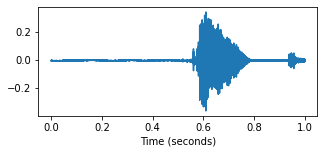

In [11]:
# plot the waveform for one example (e.g., sc_training[150])

y = sc_training[11139][0][0]
x = np.arange(len(y)) / 16000

plt.figure(figsize=(5,2))
plt.plot(x, y)
plt.xlabel("Time (seconds)")
plt.axis("tight")

# play the audio
ipd.Audio(y, rate=16000)

### Q 3.2: Define model (3 pts)
Assume you are given the basic number of channels, `n_channels`. This model should have the following layers:
* 1-D convolutional layer with `n_channels` kernels of length 80, with a stride of 16
* 1-D batch norm layer
* ReLU
* 1-D max pooling layer with kernel size 4, stride 4
* 1-D convolutional layer with `n_channels` kernels of size 3, with a stride of 1
* 1-D batch norm layer
* ReLU
* 1-D max pooling layer with same parameters as above
* 1-D convolutional layer with `2*n_channels` kernels of size 3, with a stride of 1
* 1-D batch norm layer
* ReLU
* 1-D max pooling with same parameters as above
* 1-D convolutional layer with `2*n_channels` kernels of size 3, with a stride of 1
* 1-D batch norm layer
* ReLU
* 1-D max pooling with same parameters as above
* average pooling across all remaining timepoints (see `AdaptiveAvgPool1d`)
* flattening
* Linear layer with `2*n_channels` inputs and 10 outputs

In [12]:
class WordRecognizer(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=16, n_channel=32):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=n_input, out_channels=n_channel, kernel_size=80, stride=stride),
            nn.BatchNorm1d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            
            nn.Conv1d(in_channels=n_channel, out_channels=n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            
            nn.Conv1d(in_channels=n_channel, out_channels=2*n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(num_features=2*n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            
            nn.Conv1d(in_channels=2*n_channel, out_channels=2*n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(num_features=2*n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            
            nn.AdaptiveAvgPool1d(output_size=1),
            
            nn.Flatten(),            
            nn.Linear(in_features=2*n_channel, out_features=n_output)
        )

    def forward(self, x):
        return self.layers(x)


# model = WordRecognizer(n_input=transformed.shape[0], n_output=len(sel_labels), n_channel=32)
model = WordRecognizer(n_input=1, n_output=len(sel_labels), n_channel=32)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

WordRecognizer(
  (layers): Sequential(
    (0): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=4, stride=4, padding=0, dilati

### Q 3.3: Write the training and test functions (5 pts)
Remember you need to transform the data (using the `transform` function) before you put it into the model!

In [13]:
# Run this cell first

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
# let's use StepLR to reduce the learning after 20 epochs by a factor of 10
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) 
lossfunction = nn.CrossEntropyLoss()

In [14]:
# write a function that does one training epoch
def train_one_epoch(model):
    model.train()
    total_loss = 0
    count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model.forward(transform(inputs))
        print(outputs, labels)
        loss = lossfunction(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
    with torch.no_grad():
        total_loss = 0
        count = 0
        for inputs, labels in val_loader:
            outputs = model(transform(inputs))
            loss = lossfunction(outputs, labels)
            total_loss += loss.item()
            count += 1
        val_loss = total_loss/count
        print('{:>12s} {:>7.5f}'.format('Val loss:', val_loss))
    return val_loss
    

# write a function that computes & prints test accuracy 
# (hint: use the `number_of_correct` and `get_likely_index` functions)
def test(model):
    model.eval()
    total_correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(transform(inputs))
        predicted = get_likely_index(outputs)
        total_correct += number_of_correct(predicted, labels)
        total += len(labels)
    acc = 100 * total_correct / total
    print('{:>12s} {:>7.5f}'.format('Test acc:', acc))
    return acc

### Q 3.4: Fit the model! Tweak until you get test accuracy of at least 80% (3 pts)

In [32]:
n_epoch = 20

val_losses = []
early_exit_thresh = 1.01

for epoch in range(n_epoch):
    print('EPOCH %d'%epoch)
    val_loss = train_one_epoch(model)
    val_losses.append(val_loss)
    test(model)
    scheduler.step()
    print()
    if len(val_losses) > 3 and (min(val_losses[-6:]) > (min(val_losses) * early_exit_thresh) or min(val_losses[-12:]) > min(val_losses)):
        print('Early exitting due to increasing/stagnant validation loss')
        break

EPOCH 0
 Train loss: 1.57778
   Val loss: 1.38810
   Test acc: 53.27490

EPOCH 1
 Train loss: 1.07635
   Val loss: 0.92974
   Test acc: 65.57098

EPOCH 2
 Train loss: 0.90921
   Val loss: 0.79321
   Test acc: 71.21987

EPOCH 3
 Train loss: 0.82776
   Val loss: 0.79144
   Test acc: 73.09472

EPOCH 4
 Train loss: 0.76161
   Val loss: 0.68984
   Test acc: 75.52958

EPOCH 5
 Train loss: 0.72070
   Val loss: 0.65725
   Test acc: 76.26004

EPOCH 6
 Train loss: 0.69482
   Val loss: 0.66125
   Test acc: 77.03920

EPOCH 7
 Train loss: 0.66770
   Val loss: 0.62124
   Test acc: 77.20964

EPOCH 8
 Train loss: 0.64590
   Val loss: 0.69278
   Test acc: 77.06355

EPOCH 9
 Train loss: 0.63217
   Val loss: 0.58335
   Test acc: 80.59411

EPOCH 10
 Train loss: 0.60510
   Val loss: 0.55883
   Test acc: 81.08108

EPOCH 11
 Train loss: 0.59253
   Val loss: 0.59100
   Test acc: 79.86365

EPOCH 12
 Train loss: 0.57071
   Val loss: 0.62918
   Test acc: 78.74361

EPOCH 13
 Train loss: 0.59643
   Val loss: 0.585

### Q 3.5: Create contingency matrix to show performance (2 pts)
`contingency` should be a 10x10 matrix where each row is a predicted label and each column a true label. The value of each element in this matrix should be the number of times a test example with the true label given by the column was assigned the predicted label given by the row. For example, if the predicted label for an example was "seven" but the true label was "six", then you should add one to `contingency[7,6]`. Do this for all examples in the test set.

This is a nice way to visualize how well the model is working.

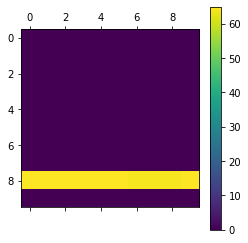

In [15]:
all_preds = []
all_targets = []

# get predictions for each test example. you can use same methods as `test` function, above
model.eval()
for inputs, labels in test_loader:
    outputs = model(transform(inputs))
    predicted = get_likely_index(outputs)
    all_preds.append(predicted)
    all_targets.append(labels)

# create contingency table
contingency = np.zeros((10, 10))
for ix in range(len(all_preds)):
    contingency[all_preds[ix], all_targets[ix]] += 1

plt.matshow(contingency)
plt.colorbar()

### Q 3.6: Create a new model and use it to generate optimized inputs (10 pts)
Finally, let's try to generate new sounds that would maximally activate each of the output units in our `WordRecognizer` model. Input optimization is one type of feature visualization (in this case, "audiolization") that can help understand how a model works.

We will do this by using gradient backpropagation to generate sounds that maximally activate each of the `WordRecognizer` outputs. This requires us to define a new model, `InputOptim`, which has one parameter tensor: `optimized_input`, the input that it is trying to optimize. In its `forward` method, this model should apply the pretrained `WordRecognizer` to its `optimized_input` and return the result. We will then use some optimizer (e.g. Adam) to make the `WordRecognizer` output the desired value. We will repeat this for each of the output classes ("zero", "one", "two", etc.). Then we will check to make sure that this works correctly (after optimization, the `WordRecognizer` should be 100% certain that the optimized input belongs to the desired class) and listen to the resulting sounds.

There are two things that you should consider here:
* How should you initialize `optimized_input`? There are many possibilities, and this choice will greatly affect your result.
* How should you do the optimization? Number of epochs, weight decay, and other optimization choices will also have a big effect on your result.

At the end of the problem you will be asked to write down some observations.

In [101]:
# first, define the new model
# this model should have one parameter tensor: the input vector you are optimization
# its `forward` function should apply the pretrained `WordRecognizer` model to this model's `optimized_input`

class InputOptim(nn.Module):
    def __init__(self, recognizer_model, input_shape=(1,1,8000)):
        super().__init__()
        self.recognizer_model = recognizer_model
#         self.optimized_input = torch.randn(input_shape, requires_grad=True) # initialize parameter tensor, should have requires_grad=True
        sound_input = transform(sc_training[11139][0]).unsqueeze(0)
        self.optimized_input = sound_input.clone().detach().requires_grad_(True)
        
    def forward(self):
        return self.recognizer_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [103]:
# next, train 10 `InputOptim` models, one for each output class ("zero", "one", etc.)
targets = torch.arange(10).long()
opt_stims = []

n_epochs = 1000

for t in targets:
    input_model = InputOptim(model)
    optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-2) # make sure this only optimizes the `input_model` parameters!
    lossfxn = nn.CrossEntropyLoss()
    
    target = torch.zeros(10)
    target[t] = 2
    
    print("target: ", t)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = input_model.forward().squeeze()
        loss = lossfxn(output, target)
        loss.backward()
        optimizer.step()
    
#     print(len(input_model.optimized_input.detach().numpy()[0][0]))
    
    opt_stims.append(input_model.optimized_input.detach().numpy())

target:  tensor(0)
target:  tensor(1)
target:  tensor(2)
target:  tensor(3)
target:  tensor(4)
target:  tensor(5)
target:  tensor(6)
target:  tensor(7)
target:  tensor(8)
target:  tensor(9)


Expected: zero. Predicted: zero.
Expected: one. Predicted: one.
Expected: two. Predicted: two.
Expected: three. Predicted: three.
Expected: four. Predicted: four.
Expected: five. Predicted: five.
Expected: six. Predicted: six.
Expected: seven. Predicted: seven.
Expected: eight. Predicted: eight.
Expected: nine. Predicted: nine.


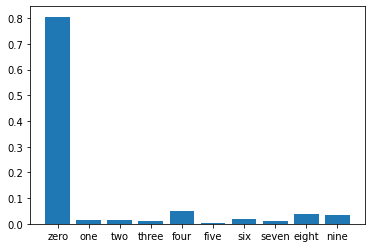

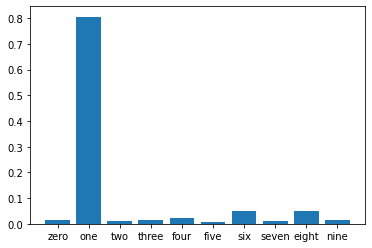

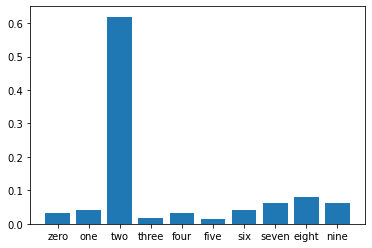

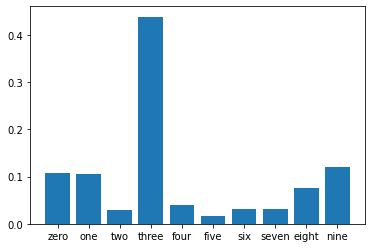

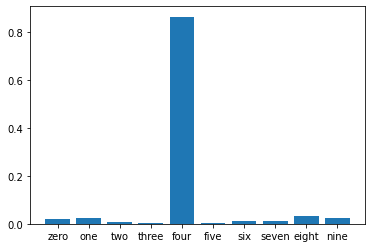

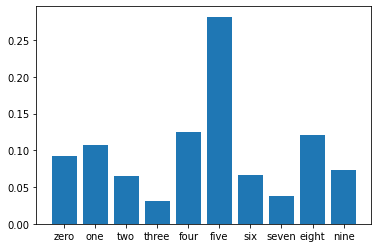

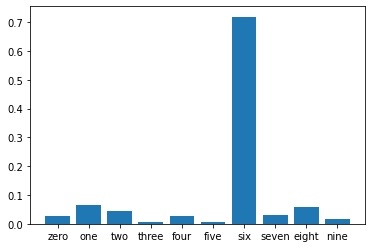

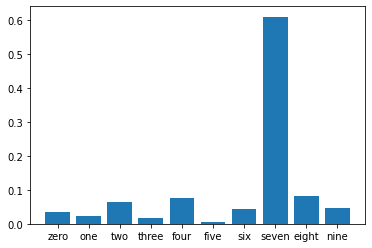

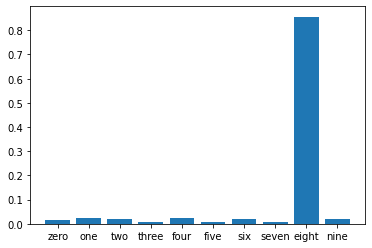

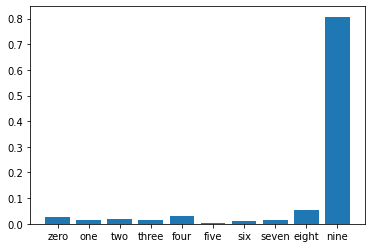

In [104]:
# finally, use this cell to see model predictions for the optimized inputs & listen to the sounds

def predict(tensor):
    # Use the model to predict the label of the waveform
    logits = model(tensor.unsqueeze(0))
    tensor = get_likely_index(logits)
    tensor = sel_labels[tensor.squeeze().item()]
    return logits.squeeze().detach().numpy(), tensor

for ind in range(10):
    utterance = sel_labels[ind]

    probs, pred = predict(torch.Tensor(opt_stims[ind].reshape(1,8000)))
    print(f"Expected: {utterance}. Predicted: {pred}.")
    
    plt.figure()
    plt.bar(range(10), np.exp(probs) / np.exp(probs).sum())
    plt.xticks(range(10), sel_labels)

    ipd.Audio(opt_stims[ind].squeeze(), rate=8000)

In [109]:
# for ind in range(10):
#     ipd.Audio(opt_stims[ind].squeeze(), rate=8000)
ipd.Audio(opt_stims[0].squeeze(), rate=8000)
# ipd.Audio(sc_training[17000][0].squeeze(), rate=16000)

### Q 3.7: What happens if you initialize `InputOptim` using a real sound, such as one of the training examples? What does this tell us about how this model works? (2 pts)

Firstly, if we initilize the parameters of InputOptim using a random uniform distribution, the optimized sounds are just static. Although the accuracy looks perfect, it seems that the most optimal way to predict a certain number is not actually using a sound byte of that number, but instead just a combination of inputs that happens to optimize for a number.

However, when I used a real sound as the input, the majority of the optimized inputs actually had intelligible sounds. While a few of the outputs, like zero and four, were still mostly static, the rest of the numbers had a quiet voice saying a number, although they had a large amount of static in front as well.

This tells us that while this model seems quite good at classifying sounds, the reverse direction of reproducing sounds from the output is quite difficult for it. Even when given a real sound as input, it has a hard time transforming that into a sound of another number.